Processing...
Done!
Estimated accuracy: 54.02%
Final result accuracy: 78.26%
Final result recall: 90.48%
Final result score: 83.93%
     loan_id  status
0       6346       1
1       6913       1
2       6014       1
3       5117       1
4       5419       1
..       ...     ...
349     7200       1
350     7171      -1
351     6470      -1
352     5933      -1
353     5841      -1

[354 rows x 2 columns]


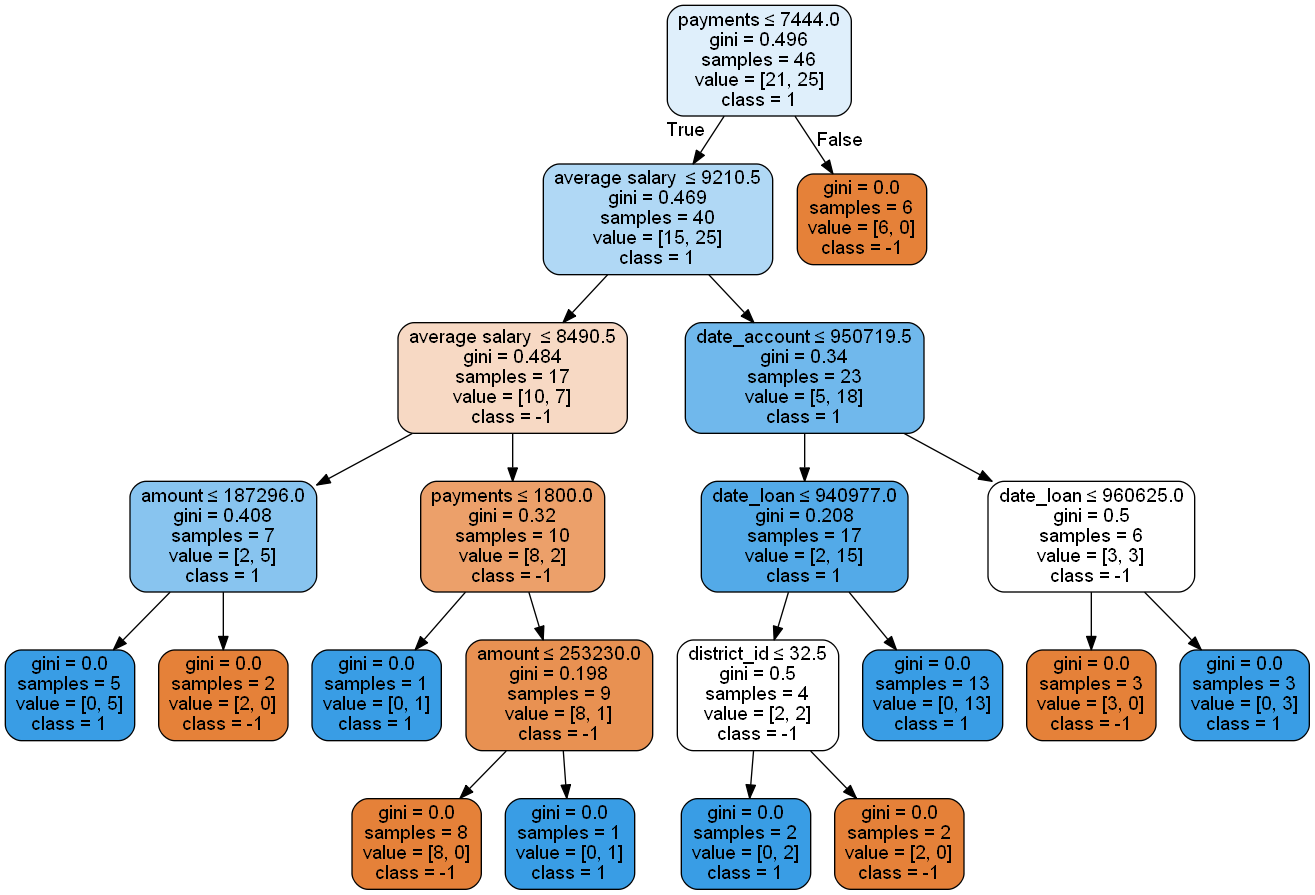

In [193]:
import pandas as pd, numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score
import os
cwd = os.path.abspath(os.getcwd())

loan_file_path = cwd + '/assets/loan_train.csv'
final_file_path = cwd + '/assets/loan_test.csv'
account_file_path = cwd + '/assets/account.csv'
district_file_path = cwd + '/assets/district.csv'
#client_file_path = cwd + '/assets/client.csv'
#disp_file_path = cwd + '/assets/disp.csv'

loan_data = pd.read_csv(loan_file_path, sep=";")
final_data = pd.read_csv(final_file_path, sep=";")
account_data = pd.read_csv(account_file_path, sep=";")
district_data = pd.read_csv(district_file_path, sep=";")
#client_data = pd.read_csv(client_file_path, sep=";")
#disp_data = pd.read_csv(disp_file_path, sep=";")

training_data = account_data.merge(loan_data, on='account_id', suffixes=['_account','_loan'])
training_data = district_data.merge(training_data, left_on='code ', right_on='district_id')
training_data = training_data.drop(columns=['account_id', 'code ', 'name ', 'region', 'loan_id'])
training_data['unemploymant rate \'95 '] = np.where(training_data['unemploymant rate \'95 '] == '?', training_data['unemploymant rate \'96 '], training_data['unemploymant rate \'95 '])
training_data['unemploymant rate \'95 '] = pd.to_numeric(training_data['unemploymant rate \'95 '], errors='coerce')
training_data['no. of commited crimes \'95 '] = np.where(training_data['no. of commited crimes \'95 '] == '?', training_data['no. of commited crimes \'96 '], training_data['no. of commited crimes \'95 '])
training_data['no. of commited crimes \'95 '] = pd.to_numeric(training_data['no. of commited crimes \'95 '], errors='coerce')
d = {'issuance after transaction': 0, 'monthly issuance': 1, 'weekly issuance': 2 }
training_data['frequency'] = training_data['frequency'].map(d)

average_score = 0
average_accuracy = 0
average_recall = 0
n_test = 2000
best_score = 0
best_accuracy = 0
best_recall = 0

for x, temp in training_data.groupby('status'):
    if x == -1:
        t1 == temp
    if x == 1:
        t2 == temp
        
ntd = t1.append(t2.sample(n=len(t1.index)))

print('Processing...')
for x in range(n_test):

    sampled_data = np.array_split(ntd.sample(frac=1),2)
    train_data = sampled_data[0]
    test_data = sampled_data[1]

    y = train_data.status
    x = train_data.drop(columns=['status'])

    #criterion="gini", splitter="random", max_depth=5
    dtree = DecisionTreeClassifier(max_depth=6)
    dtree = dtree.fit(x,y)
    y_pred = dtree.predict(test_data.drop(columns=['status']))
    y_test = test_data.status

    cur_accuracy = accuracy_score(y_test, y_pred)
    cur_recall = recall_score(y_test, y_pred)
    
    cur_score = 2 * (cur_accuracy * cur_recall)/(cur_accuracy + cur_recall)
    
    average_score += cur_score
    average_accuracy += cur_accuracy
    average_recall += cur_recall
    
    if cur_score > best_score:
        btree = dtree
        best_score = cur_score
        best_accuracy = cur_accuracy
        best_recall = cur_recall


average_score /= n_test
average_accuracy /= n_test
average_recall /= n_test


print(f'Done!\nEstimated accuracy: {average_score:.2%}')
print(f'Final result accuracy: {best_accuracy:.2%}')
print(f'Final result recall: {best_recall:.2%}')
print(f'Final result score: {best_score:.2%}')

predict_data = account_data.merge(final_data, on='account_id', suffixes=['_account','_loan'])
predict_data = district_data.merge(predict_data, left_on='code ', right_on='district_id')
predict_data = predict_data.drop(columns=['account_id', 'code ', 'name ', 'region'])
predict_data['unemploymant rate \'95 '] = np.where(predict_data['unemploymant rate \'95 '] == '?', predict_data['unemploymant rate \'96 '], predict_data['unemploymant rate \'95 '])
predict_data['unemploymant rate \'95 '] = pd.to_numeric(predict_data['unemploymant rate \'95 '], errors='coerce')
predict_data['no. of commited crimes \'95 '] = np.where(predict_data['no. of commited crimes \'95 '] == '?', predict_data['no. of commited crimes \'96 '], predict_data['no. of commited crimes \'95 '])
predict_data['no. of commited crimes \'95 '] = pd.to_numeric(predict_data['no. of commited crimes \'95 '], errors='coerce')
d = {'issuance after transaction': 0, 'monthly issuance': 1, 'weekly issuance': 2 }
predict_data['frequency'] = predict_data['frequency'].map(d)

predict_data['status'] = btree.predict(predict_data.drop(columns=['status','loan_id']))

from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(btree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = test_data.drop(columns=['status']).columns,class_names=['-1','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('result.png')
print(predict_data[['loan_id','status']])
predict_data[['loan_id','status']].rename(columns={'loan_id': 'Id','status': 'Predicted'}).to_csv('result.csv', index=False)
Image(graph.create_png())


